In [2]:
import numpy as np
import os
import glob
import h5py
from scipy.stats import zscore
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import binned_statistic
from skimage.feature import peak_local_max
import seaborn as sns
from scipy.signal import convolve2d
import pandas as pd
import numpy as np
import scipy

In [3]:
def calculate_cog(frequencies, angles, amplitudes, ratio):
    """
       Calculate the Center of Gravity (CoG) of an FPP plots of cycles.

       Parameters:
       frequencies (numpy.ndarray): An array of frequencies corresponding to FPP frequencies.
       angles (numpy.ndarray): An array of phase angles in degrees.
       amplitudes (numpy.ndarray): An array of magnitude values (can be power).
           - If 2D, it represents magnitude values for multiple frequency bins.
           - If 3D, it represents magnitude values for multiple frequency bins across multiple trials or subjects.
       ratio (float): A ratio threshold for selecting magnitude values in the phase direction .

       Returns:
       numpy.ndarray: The Center of Gravity (CoG) for the FPP plot as frequency and phase.
           - For 2D amplitudes: A 2D array containing CoG values for frequency and phase.
           - For 3D amplitudes: A 2D array containing CoG values for frequency and phase cycle.

       Notes:
       - This function calculates the Center of Gravity (CoG) of the FPP plots.
       - It can handle 2D or 3D amplitude arrays, representing either single or multiple cycles.
       """
    angles = np.deg2rad(angles)
    cog = np.empty((0, 2))

    if amplitudes.ndim == 2:
        numerator = np.sum(frequencies * np.sum(amplitudes, axis=1))
        denominator = np.sum(amplitudes)
        cog_f = numerator / denominator
        floor = np.floor(cog_f).astype(int) - frequencies[0]
        ceil = np.ceil(cog_f).astype(int) - frequencies[0]
        new_fpp = np.where(amplitudes >= np.max(amplitudes[[floor, ceil], :]) * ratio, amplitudes, 0)
        cog_ph = np.rad2deg(pg.circ_mean(angles, w=np.sum(new_fpp, axis=0)))
        cog = np.array([cog_f, cog_ph])

    elif amplitudes.ndim == 3:
        indices_to_subset = np.empty((amplitudes.shape[0], 2)).astype(int)
        cog = np.empty((amplitudes.shape[0], 2))
        numerator = np.sum(frequencies * np.sum(amplitudes, axis=2), axis=1)
        denominator = np.sum(amplitudes, axis=(1, 2))
        cog_f = (numerator / denominator)

        vectorized_floor = np.vectorize(np.floor)
        vectorized_ceil = np.vectorize(np.ceil)
        indices_to_subset[:, 0] = vectorized_floor(cog_f) - frequencies[0]
        indices_to_subset[:, 1] = vectorized_ceil(cog_f) - frequencies[0]

        max_amps = np.max(amplitudes[np.arange(amplitudes.shape[0])[:, np.newaxis], indices_to_subset, :], axis=(1, 2))
        print(max_amps.shape)

        for i, max_amp in enumerate(max_amps):
            new_fpp = np.where(amplitudes[i] >= max_amp * ratio, amplitudes[i], 0)
            cog[i, 1] = np.rad2deg(pg.circ_mean(angles, w=np.sum(new_fpp, axis=0)))
        cog[:, 0] = cog_f

    return cog
def peak_cog(frequencies, angles, amplitudes, ratio):
    """
       Calculate the Center of Gravity (CoG) and snap to the nearest peak in the FPP array.

       Parameters:
       frequencies (numpy.ndarray): An array of frequencies.
       angles (numpy.ndarray): An array of phase angles in degrees.
       amplitudes (numpy.ndarray): An array of magnitude values (can be power).
           - If 2D, it represents magnitude values for multiple phase bins.
           - If 3D, it represents magnitude values for multiple phase bins across multiple trials or subjects.
       ratio (float): A ratio threshold for selecting magnitude values in the phase direction.

       Returns:
       numpy.ndarray: Snapped peaks of each FPP cycle .
           - For 2D amplitudes: A 2D array containing CoG peaks for frequency and phase.
           - For 3D amplitudes: A 2D array containing CoG peaks for frequency and phase for each cycle.

       Notes:
       - This function calculates the Center of Gravity (CoG) of the passed FPP cycles and their respective magnitude
       peaks.
       - The CoG is then shifted to the nearest peak of Euclidean distance treating frequency as linear and phase as
       circular.
       """

    def nearest_peaks(frequency, angle, amplitude, ratio):
        peak_indices = peak_local_max(amplitude, min_distance=1, threshold_abs=0)
        cog_f = calculate_cog(frequency, angle, amplitude, ratio)

        if peak_indices.shape[0] == 0:
            cog_peak = cog_f
        else:
            cog_fx = np.array([cog_f[0], cog_f[0] * np.cos(np.deg2rad(cog_f[1] - angle[0])),
                               cog_f[0] * np.sin(np.deg2rad(cog_f[1] - angle[0]))])
            peak_loc = peak_loc = np.empty((peak_indices.shape[0], 4))
            peak_loc[:, [0, 1]] = np.array([frequency[peak_indices.T[0]], angle[peak_indices.T[1]]]).T
            peak_loc[:, 2] = peak_loc[:, 0] * np.cos(np.deg2rad(peak_loc[:, 1] - angle[0]))
            peak_loc[:, 3] = peak_loc[:, 0] * np.sin(np.deg2rad(peak_loc[:, 1] - angle[0]))
            peak_loc = peak_loc[:, [0, 2, 3]]
            distances = np.abs(peak_loc - cog_fx)

            cog_pos = peak_indices[np.argmin(np.linalg.norm(distances, axis=1))]

            cog_peak = np.array([frequency[cog_pos[0]], angle[cog_pos[1]]])

        return cog_peak

    if amplitudes.ndim == 2:
        cog = nearest_peaks(frequencies, angles, amplitudes, ratio)
    elif amplitudes.ndim == 3:
        cog = np.empty((amplitudes.shape[0], 2))
        for i, fpp in enumerate(amplitudes):
            cog[i] = nearest_peaks(frequencies, angles, fpp, ratio)
    else:
        # Add a default assignment for other cases
        cog = np.empty((0, 2))
    return cog

def bin_tf_to_fpp(x, power, bin_count):
    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp
def boxcar_smooth(x, boxcar_window):
    """
    Smooth a 1D or 2D array using a boxcar window.

    Parameters:
    - x (numpy.ndarray): Input array to be smoothed.
    - boxcar_window (int or tuple): Size of the boxcar window for smoothing.
      For 1D array, an integer representing the window size.
      For 2D array, a tuple (t, f) representing window sizes along the time (t) and frequency (f) dimensions.

    Returns:
    - numpy.ndarray: Smoothed array using the boxcar window.

    Notes:
    - If the input array is 1D, the boxcar window size is adjusted to be odd.
    - If the input array is 2D, separate boxcar windows are created for the time (t) and frequency (f) dimensions.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal_1d = np.random.rand(100)  # Replace with your actual 1D signal
    window_size_1d = 5
    smoothed_1d = boxcar_smooth(signal_1d, window_size_1d)
    print(smoothed_1d)

    signal_2d = np.random.rand(100, 50)  # Replace with your actual 2D signal
    window_size_2d = (5, 3)
    smoothed_2d = boxcar_smooth(signal_2d, window_size_2d)
    print(smoothed_2d)
    ```
    """
    # Check if the input array x is 1-dimensional
    if x.ndim == 1:
        # Check if the boxcar window size is even, and if so, make it odd by adding 1
        if boxcar_window % 2 == 0:
            boxcar_window += 1
        # Create a boxcar window of size boxcar_window for smoothing
        window = np.ones((1, boxcar_window)) / boxcar_window
        # Perform 1-dimensional convolution to smooth the input array x
        x_spectrum = np.convolve(x, window, mode='same')
    else:
        # Adjust the boxcar window size to be odd for both dimensions
        bool_window = np.where(~np.array(boxcar_window) % 2 == 0, boxcar_window, np.array(boxcar_window) + 1)
        # Create separate boxcar windows for time (t) and frequency (f) dimensions
        window_t = np.ones((1, bool_window[0])) / bool_window[0]
        window_f = np.ones((1, bool_window[1])) / bool_window[1]
        # Perform 2-dimensional convolution first along the time dimension (t)
        x_spectrum_t = convolve2d(x, window_t, mode='same')
        # Perform 2-dimensional convolution along the frequency dimension (f)
        x_spectrum = convolve2d(x_spectrum_t, window_f.T, mode='same')
    # Return the smoothed array x_spectrum
    return x_spectrum


In [ ]:
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1', '3','4', '9', '11', '13']

#histogram_counts = np.zeros(len(histogram_bins) - 1)
frequencies = np.arange(20, 140, 1)
angles = np.arange(-180,180,19)

# Accumulate CoG frequencies across all REM states and datasets
all_cog_frequencies = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))
                    
                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                # Print debugging information
                                print(f"Processing file: {hdf5_file_path}")
                                print(f"Available groups: {list(hdf_file.keys())}")
                                current_group = hdf_file[group_name]

                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())
                                subset_frequencies = np.arange(20, 140, 1)
                                for rem_key in rem_dict_keys:
                                    # Access the 'wavelet_transform' key for the current REM period
                                    wavelet_transform = hdf_file[group_name][rem_key]['wavelet_transform'][:]
                                    print(f"The shape of wavelet_transform for {rem_key} is: {wavelet_transform.shape}")

                                    # Square each value in the matrix to get power
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                    
                                    # Z-score along the frequency axis
                                    power = zscore(power_matrix, axis=0)
                                    #power=power_matrix
                                    shifted_power = power + np.abs(np.min(power))
                                    shifted_smoothed_power = boxcar_smooth(shifted_power, (5, 21))
                                    start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                    fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                    # Calculate mean power values for the subset of frequencies
                                    fpp_plots = bin_tf_to_fpp(newcycles, shifted_smoothed_power, 19)
  
                                    
                                    
                                    x = peak_cog(frequencies, angles, fpp_plots, 0.95)
                                    # optional
                                    all_cog_frequencies.extend(x)
                                    # Import necessary libraries
                                    #import os
                                    #import pandas as pd

                                    # Specify the directory for the CSV file
                                    #csv_directory = 'E:/Donders/Weekly meeting'

                                    # Specify the name of the CSV file
                                    #csv_file_name = 'output_file.csv'

                                    # Combine the directory and file name to create the complete file path
                                    #csv_file_path = os.path.join(csv_directory, csv_file_name)

                                    # Convert the NumPy array to a DataFrame
                                    #df = pd.DataFrame(all_cog_frequencies, columns=['Column1', 'Column2'])

                                    # Save the DataFrame to a CSV file
                                    #df.to_csv(csv_file_path, index=False)

                                    #plt.hist(cog_frequencies, bins=histogram_bins, edgecolor='black')
                                    
                                    #plt.xlabel('CoG Frequency')
                                    #plt.ylabel('Frequency of Occurrence')
                                    #plt.title('Distribution of CoG Frequencies')

                                    # Show the plot
                                    #plt.show()

                                else:  # This else statement should be aligned with the inner for loop
                                    print(f"Group '{group_name}' not found in the HDF5 file.")
all_cog_frequencies = np.array(all_cog_frequencies)
# Assuming non_empty_cog_frequencies is your 2D array
g = sns.jointplot(x=all_cog_frequencies[:, 0], y=all_cog_frequencies[:, 1], kind='kde', fill=False)

# Set axis labels and plot title
g.set_axis_labels('CoG Frequency', 'CoG Phase')
g.fig.suptitle('CoG Distribution PFC: Rat 1/CN/posttrial 5')

# Adjust layout to make room for the title
g.fig.subplots_adjust(top=0.9)

# Show the plot
plt.show()





Processing file: E:\Donders\1\processed\CN\post_trial1_2017-09-28_11-30-59\post_trial1_2017-09-28_11-30-59_REM_dict.h5
Available groups: ['post_trial1_2017-09-28_11-30-59']
The shape of wavelet_transform for REM 1 is: (120, 212500)
Group 'post_trial1_2017-09-28_11-30-59' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\CN\post_trial2_2017-09-28_12-21-41\post_trial2_2017-09-28_12-21-41_REM_dict.h5
Available groups: ['post_trial2_2017-09-28_12-21-41']
The shape of wavelet_transform for REM 1 is: (120, 157500)
Group 'post_trial2_2017-09-28_12-21-41' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\CN\post_trial3_2017-09-28_13-12-53\post_trial3_2017-09-28_13-12-53_REM_dict.h5
Available groups: ['post_trial3_2017-09-28_13-12-53']
The shape of wavelet_transform for REM 1 is: (120, 52500)
The shape of wavelet_transform for REM 2 is: (120, 145000)
The shape of wavelet_transform for REM 3 is: (120, 47500)
The shape of wavelet_transform for REM 4 is: (120, 7

The shape of wavelet_transform for REM 1 is: (120, 157500)
The shape of wavelet_transform for REM 2 is: (120, 157500)
Group 'post_trial1_2017-09-25_11-26-43' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\study_day_2_OR\post_trial2_2017-09-25_12-17-49\post_trial2_2017-09-25_12-17-49_REM_dict.h5
Available groups: ['post_trial2_2017-09-25_12-17-49']
The shape of wavelet_transform for REM 1 is: (120, 15000)
The shape of wavelet_transform for REM 2 is: (120, 5000)
The shape of wavelet_transform for REM 3 is: (120, 20000)
The shape of wavelet_transform for REM 4 is: (120, 27500)
The shape of wavelet_transform for REM 5 is: (120, 15000)
Group 'post_trial2_2017-09-25_12-17-49' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\study_day_2_OR\post_trial3_2017-09-25_13-08-52\post_trial3_2017-09-25_13-08-52_REM_dict.h5
Available groups: ['post_trial3_2017-09-25_13-08-52']
The shape of wavelet_transform for REM 1 is: (120, 150000)
The shape of wavelet_transfo

Group 'post_trial1_2017-11-16_11-23-46' not found in the HDF5 file.
Processing file: E:\Donders\3\processed\OD\post_trial2_2017-11-16_12-14-17\post_trial2_2017-11-16_12-14-17_REM_dict.h5
Available groups: ['post_trial2_2017-11-16_12-14-17']
The shape of wavelet_transform for REM 1 is: (120, 232500)
Group 'post_trial2_2017-11-16_12-14-17' not found in the HDF5 file.
Processing file: E:\Donders\3\processed\OD\post_trial3_2017-11-16_13-04-51\post_trial3_2017-11-16_13-04-51_REM_dict.h5
Available groups: ['post_trial3_2017-11-16_13-04-51']
The shape of wavelet_transform for REM 1 is: (120, 182500)
The shape of wavelet_transform for REM 2 is: (120, 505000)
The shape of wavelet_transform for REM 3 is: (120, 342500)
Group 'post_trial3_2017-11-16_13-04-51' not found in the HDF5 file.
Processing file: E:\Donders\3\processed\OD\post_trial4_2017-11-16_13-55-23\post_trial4_2017-11-16_13-55-23_REM_dict.h5
Available groups: ['post_trial4_2017-11-16_13-55-23']
The shape of wavelet_transform for REM 1 

The shape of wavelet_transform for REM 1 is: (120, 217500)
The shape of wavelet_transform for REM 2 is: (120, 152500)
Group 'post_trial4_2017-11-21_13-25-29' not found in the HDF5 file.
Processing file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD5_OR_N_21-22_11_2017\post_trial5_2017-11-21_14-49-47\post_trial5_2017-11-21_14-49-47_REM_dict.h5
Available groups: ['post_trial5_2017-11-21_14-49-47']
The shape of wavelet_transform for REM 1 is: (120, 432500)
The shape of wavelet_transform for REM 2 is: (120, 190000)
The shape of wavelet_transform for REM 3 is: (120, 285000)
The shape of wavelet_transform for REM 4 is: (120, 377500)
The shape of wavelet_transform for REM 5 is: (120, 202500)
The shape of wavelet_transform for REM 6 is: (120, 162500)
The shape of wavelet_transform for REM 7 is: (120, 80000)
The shape of wavelet_transform for REM 8 is: (120, 567500)
Group 'post_trial5_2017-11-21_14-49-47' not found in the HDF5 file.
Processing file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD5_OR

The shape of wavelet_transform for REM 1 is: (120, 300000)
The shape of wavelet_transform for REM 10 is: (120, 40000)
The shape of wavelet_transform for REM 11 is: (120, 135000)
The shape of wavelet_transform for REM 12 is: (120, 82500)
The shape of wavelet_transform for REM 13 is: (120, 245000)
The shape of wavelet_transform for REM 14 is: (120, 340000)
The shape of wavelet_transform for REM 2 is: (120, 122500)
The shape of wavelet_transform for REM 3 is: (120, 312500)
The shape of wavelet_transform for REM 4 is: (120, 190000)
The shape of wavelet_transform for REM 5 is: (120, 55000)
The shape of wavelet_transform for REM 6 is: (120, 150000)
The shape of wavelet_transform for REM 7 is: (120, 310000)
The shape of wavelet_transform for REM 8 is: (120, 242500)
The shape of wavelet_transform for REM 9 is: (120, 40000)
Group 'post_trial5_2017-12-21_16-02-00' not found in the HDF5 file.
Processing file: E:\Donders\4\processed\OD\presleep_2017-12-21_11-48-07\presleep_2017-12-21_11-48-07_REM_

The shape of wavelet_transform for REM 1 is: (120, 212500)
The shape of wavelet_transform for REM 2 is: (120, 327500)
Group 'post_trial4_2017-12-18_13-08-50' not found in the HDF5 file.
Processing file: E:\Donders\4\processed\Rat_OS_Ephys_Rat4_SD4_OR_N_18-19_12_2017\post_trial5_2017-12-18_14-30-11\post_trial5_2017-12-18_14-30-11_REM_dict.h5
Available groups: ['post_trial5_2017-12-18_14-30-11']
The shape of wavelet_transform for REM 1 is: (120, 282500)
The shape of wavelet_transform for REM 10 is: (120, 230000)
The shape of wavelet_transform for REM 11 is: (120, 135000)
The shape of wavelet_transform for REM 12 is: (120, 82500)
The shape of wavelet_transform for REM 2 is: (120, 350000)
The shape of wavelet_transform for REM 3 is: (120, 322500)
The shape of wavelet_transform for REM 4 is: (120, 40000)
The shape of wavelet_transform for REM 5 is: (120, 202500)
The shape of wavelet_transform for REM 6 is: (120, 80000)
The shape of wavelet_transform for REM 7 is: (120, 162500)
The shape of 

The shape of wavelet_transform for REM 1 is: (120, 267500)
Group '2018-06-27_10-04-32_Post_Trial1' not found in the HDF5 file.
Processing file: E:\Donders\9\processed\2018_06_27_Study_day_16_or_nov\2018-06-27_10-55-01_Post_Trial2\2018-06-27_10-55-01_Post_Trial2_REM_dict.h5
Available groups: ['2018-06-27_10-55-01_Post_Trial2']
Group '2018-06-27_10-55-01_Post_Trial2' not found in the HDF5 file.
Processing file: E:\Donders\9\processed\2018_06_27_Study_day_16_or_nov\2018-06-27_11-45-36_Post_Trial3\2018-06-27_11-45-36_Post_Trial3_REM_dict.h5
Available groups: ['2018-06-27_11-45-36_Post_Trial3']
The shape of wavelet_transform for REM 1 is: (120, 110000)
The shape of wavelet_transform for REM 2 is: (120, 327500)
The shape of wavelet_transform for REM 3 is: (120, 180000)
Group '2018-06-27_11-45-36_Post_Trial3' not found in the HDF5 file.
Processing file: E:\Donders\9\processed\2018_06_27_Study_day_16_or_nov\2018-06-27_12-36-07_Post_Trial4\2018-06-27_12-36-07_Post_Trial4_REM_dict.h5
Available g

Group '2018-05-13_11-26-26_Post_Trial2' not found in the HDF5 file.
Processing file: E:\Donders\9\processed\HC\2018-05-13_12-16-38_Post_Trial3\2018-05-13_12-16-38_Post_Trial3_REM_dict.h5
Available groups: ['2018-05-13_12-16-38_Post_Trial3']
The shape of wavelet_transform for REM 1 is: (120, 147500)
The shape of wavelet_transform for REM 2 is: (120, 345000)
The shape of wavelet_transform for REM 3 is: (120, 175000)
The shape of wavelet_transform for REM 4 is: (120, 365000)
The shape of wavelet_transform for REM 5 is: (120, 107500)
Group '2018-05-13_12-16-38_Post_Trial3' not found in the HDF5 file.
Processing file: E:\Donders\9\processed\HC\2018-05-13_13-07-00_Post_Trial4\2018-05-13_13-07-00_Post_Trial4_REM_dict.h5
Available groups: ['2018-05-13_13-07-00_Post_Trial4']
The shape of wavelet_transform for REM 1 is: (120, 277500)
Group '2018-05-13_13-07-00_Post_Trial4' not found in the HDF5 file.
Processing file: E:\Donders\9\processed\HC\2018-05-13_13-57-18_Post_Trial5\2018-05-13_13-57-18_P

The shape of wavelet_transform for REM 1 is: (120, 395000)
The shape of wavelet_transform for REM 10 is: (120, 252500)
The shape of wavelet_transform for REM 11 is: (120, 22500)
The shape of wavelet_transform for REM 12 is: (120, 70000)
The shape of wavelet_transform for REM 13 is: (120, 137500)
The shape of wavelet_transform for REM 14 is: (120, 287500)
The shape of wavelet_transform for REM 15 is: (120, 17500)
The shape of wavelet_transform for REM 16 is: (120, 17500)
The shape of wavelet_transform for REM 17 is: (120, 420000)
The shape of wavelet_transform for REM 18 is: (120, 20000)
The shape of wavelet_transform for REM 19 is: (120, 182500)
The shape of wavelet_transform for REM 2 is: (120, 12500)
The shape of wavelet_transform for REM 20 is: (120, 25000)
The shape of wavelet_transform for REM 21 is: (120, 195000)
The shape of wavelet_transform for REM 22 is: (120, 2500)
The shape of wavelet_transform for REM 23 is: (120, 162500)
The shape of wavelet_transform for REM 3 is: (120, 

The shape of wavelet_transform for REM 3 is: (120, 85000)
The shape of wavelet_transform for REM 4 is: (120, 80000)
The shape of wavelet_transform for REM 5 is: (120, 347500)
The shape of wavelet_transform for REM 6 is: (120, 135000)
The shape of wavelet_transform for REM 7 is: (120, 122500)
The shape of wavelet_transform for REM 8 is: (120, 92500)
The shape of wavelet_transform for REM 9 is: (120, 280000)
Group '2018-10-31_14-39-12_Post_Trial5' not found in the HDF5 file.
Processing file: E:\Donders\11\processed\OR\2018-11-05_09-58-51_Pre-sleep\2018-11-05_09-58-51_Pre-sleep_REM_dict.h5
Available groups: ['2018-11-05_09-58-51_Pre-sleep']
Group '2018-11-05_09-58-51_Pre-sleep' not found in the HDF5 file.
Processing file: E:\Donders\11\processed\OR\2018-11-05_10-49-36_Post_Trial1\2018-11-05_10-49-36_Post_Trial1_REM_dict.h5
Available groups: ['2018-11-05_10-49-36_Post_Trial1']
The shape of wavelet_transform for REM 1 is: (120, 117500)
Group '2018-11-05_10-49-36_Post_Trial1' not found in th

Processing file: E:\Donders\1\processed\HC\post_trial1_2017-09-27_10-56-20\post_trial1_2017-09-27_10-56-20_REM_dict.h5
Available groups: ['post_trial1_2017-09-27_10-56-20']
The shape of wavelet_transform for REM 1 is: (120, 175000)
Group 'post_trial1_2017-09-27_10-56-20' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\HC\post_trial2_2017-09-27_11-46-56\post_trial2_2017-09-27_11-46-56_REM_dict.h5
Available groups: ['post_trial2_2017-09-27_11-46-56']
The shape of wavelet_transform for REM 1 is: (120, 162500)
The shape of wavelet_transform for REM 2 is: (120, 170000)
The shape of wavelet_transform for REM 3 is: (120, 27500)
Group 'post_trial2_2017-09-27_11-46-56' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\HC\post_trial3_2017-09-27_12-37-12\post_trial3_2017-09-27_12-37-12_REM_dict.h5
Available groups: ['post_trial3_2017-09-27_12-37-12']
The shape of wavelet_transform for REM 1 is: (120, 87500)
The shape of wavelet_transform for REM 2 is: (120, 1

The shape of wavelet_transform for REM 1 is: (120, 147500)
The shape of wavelet_transform for REM 2 is: (120, 25000)
The shape of wavelet_transform for REM 3 is: (120, 305000)
Group 'post_trial4_2017-12-13_11-43-15' not found in the HDF5 file.
Processing file: E:\Donders\4\processed\Rat_OS_Ephys_Rat4_SD2_HC_13_12_2017\post_trial5_2017-12-13_12-33-28\post_trial5_2017-12-13_12-33-28_REM_dict.h5
Available groups: ['post_trial5_2017-12-13_12-33-28']
The shape of wavelet_transform for REM 1 is: (120, 22500)
The shape of wavelet_transform for REM 10 is: (120, 75000)
The shape of wavelet_transform for REM 11 is: (120, 325000)
The shape of wavelet_transform for REM 12 is: (120, 325000)
The shape of wavelet_transform for REM 13 is: (120, 37500)
The shape of wavelet_transform for REM 14 is: (120, 107500)
The shape of wavelet_transform for REM 15 is: (120, 435000)
The shape of wavelet_transform for REM 16 is: (120, 147500)
The shape of wavelet_transform for REM 2 is: (120, 387500)
The shape of wa

Group 'Post_trial1_2018-02-28_10-21-35' not found in the HDF5 file.
Processing file: E:\Donders\6\processed\Study_day6_HC_28feb2018\Post_trial2_2018-02-28_11-11-49\Post_trial2_2018-02-28_11-11-49_REM_dict.h5
Available groups: ['Post_trial2_2018-02-28_11-11-49']
The shape of wavelet_transform for REM 1 is: (120, 77500)
The shape of wavelet_transform for REM 2 is: (120, 297500)
The shape of wavelet_transform for REM 3 is: (120, 110000)
The shape of wavelet_transform for REM 4 is: (120, 40000)
The shape of wavelet_transform for REM 5 is: (120, 425000)
The shape of wavelet_transform for REM 6 is: (120, 237500)
The shape of wavelet_transform for REM 7 is: (120, 217500)
The shape of wavelet_transform for REM 8 is: (120, 30000)
The shape of wavelet_transform for REM 9 is: (120, 67500)
Group 'Post_trial2_2018-02-28_11-11-49' not found in the HDF5 file.
Processing file: E:\Donders\6\processed\Study_day6_HC_28feb2018\Post_trial3_2018-02-28_12-02-02\Post_trial3_2018-02-28_12-02-02_REM_dict.h5
Ava

The shape of wavelet_transform for REM 1 is: (120, 40000)
Group '2018-11-02_10-56-09_Post_Trial1' not found in the HDF5 file.
Processing file: E:\Donders\11\processed\HC\2018-11-02_11-46-32_Post_Trial2\2018-11-02_11-46-32_Post_Trial2_REM_dict.h5
Available groups: ['2018-11-02_11-46-32_Post_Trial2']
The shape of wavelet_transform for REM 1 is: (120, 147500)
The shape of wavelet_transform for REM 2 is: (120, 537500)
The shape of wavelet_transform for REM 3 is: (120, 40000)
The shape of wavelet_transform for REM 4 is: (120, 255000)
The shape of wavelet_transform for REM 5 is: (120, 135000)
The shape of wavelet_transform for REM 6 is: (120, 247500)
Group '2018-11-02_11-46-32_Post_Trial2' not found in the HDF5 file.
Processing file: E:\Donders\11\processed\HC\2018-11-02_12-36-54_Post_Trial3\2018-11-02_12-36-54_Post_Trial3_REM_dict.h5
Available groups: ['2018-11-02_12-36-54_Post_Trial3']
The shape of wavelet_transform for REM 1 is: (120, 40000)
The shape of wavelet_transform for REM 2 is: (1

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

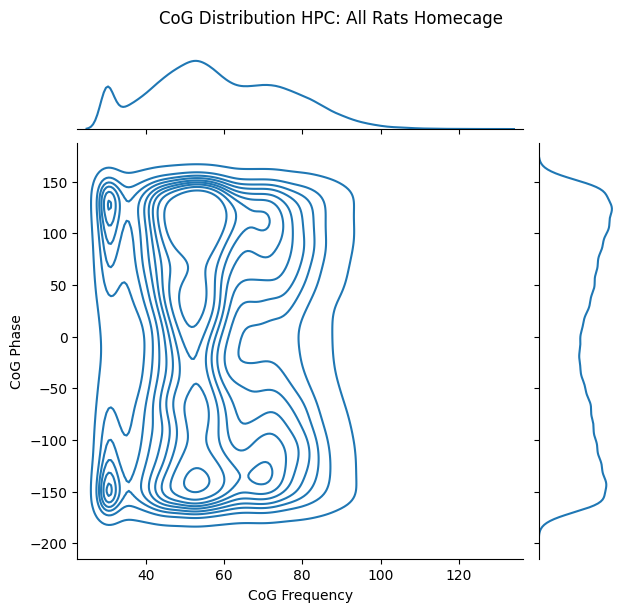

In [19]:
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"


# Define the target folders
target_folders = ['1', '3','4', '6', '9', '11', '13']

#histogram_counts = np.zeros(len(histogram_bins) - 1)
frequencies = np.arange(20, 140, 1)
angles = np.arange(-180,180,19)

# Accumulate CoG frequencies across all REM states and datasets
all_cog_frequencies = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path) and "HC" in subfolder:
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))
                    
                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                # Print debugging information
                                print(f"Processing file: {hdf5_file_path}")
                                print(f"Available groups: {list(hdf_file.keys())}")
                                current_group = hdf_file[group_name]

                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())
                                subset_frequencies = np.arange(20, 140, 1)
                                for rem_key in rem_dict_keys:
                                    # Access the 'wavelet_transform' key for the current REM period
                                    wavelet_transform = hdf_file[group_name][rem_key]['wavelet_transform'][:]
                                    print(f"The shape of wavelet_transform for {rem_key} is: {wavelet_transform.shape}")

                                    # Square each value in the matrix to get power
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                    
                                    # Z-score along the frequency axis
                                    power = zscore(power_matrix, axis=0)
                                    #power=power_matrix
                                    shifted_power = power + np.abs(np.min(power))
                                    shifted_smoothed_power = boxcar_smooth(shifted_power, (5, 21))
                                    start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                    fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                    # Calculate mean power values for the subset of frequencies
                                    fpp_plots = bin_tf_to_fpp(newcycles, shifted_smoothed_power, 19)
  
                                    
                                    
                                    x = peak_cog(frequencies, angles, fpp_plots, 0.95)
                                    # optional
                                    all_cog_frequencies.extend(x)
                                    # Import necessary libraries
                                    #import os
                                    #import pandas as pd

                                    # Specify the directory for the CSV file
                                    #csv_directory = 'E:/Donders/Weekly meeting'

                                    # Specify the name of the CSV file
                                    #csv_file_name = 'output_file.csv'

                                    # Combine the directory and file name to create the complete file path
                                    #csv_file_path = os.path.join(csv_directory, csv_file_name)

                                    # Convert the NumPy array to a DataFrame
                                    #df = pd.DataFrame(all_cog_frequencies, columns=['Column1', 'Column2'])

                                    # Save the DataFrame to a CSV file
                                    #df.to_csv(csv_file_path, index=False)

                                    #plt.hist(cog_frequencies, bins=histogram_bins, edgecolor='black')
                                    
                                    #plt.xlabel('CoG Frequency')
                                    #plt.ylabel('Frequency of Occurrence')
                                    #plt.title('Distribution of CoG Frequencies')

                                    # Show the plot
                                    #plt.show()

                                else:  # This else statement should be aligned with the inner for loop
                                    print(f"Group '{group_name}' not found in the HDF5 file.")
all_cog_frequencies = np.array(all_cog_frequencies)
# Assuming non_empty_cog_frequencies is your 2D array
g = sns.jointplot(x=all_cog_frequencies[:, 0], y=all_cog_frequencies[:, 1], kind='kde', fill=False)

# Set axis labels and plot title
g.set_axis_labels('CoG Frequency', 'CoG Phase')
g.fig.suptitle('CoG Distribution HPC: All Rats Homecage')

# Adjust layout to make room for the title
g.fig.subplots_adjust(top=0.9)

# Show the plot
plt.show()



In [ ]:
all_cog_frequencies = np.array(all_cog_frequencies)
# Assuming non_empty_cog_frequencies is your 2D array
g = sns.jointplot(x=all_cog_frequencies[:, 0], y=all_cog_frequencies[:, 1], kind='kde', fill=False)

# Set axis labels and plot title
g.set_axis_labels('CoG Frequency', 'CoG Phase')
g.fig.suptitle('CoG Distribution HPC: All Rats')

# Adjust layout to make room for the title
g.fig.subplots_adjust(top=0.9)

# Show the plot
plt.show()

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

Processing file: E:\Donders\1\processed\CN\post_trial1_2017-09-28_11-30-59\post_trial1_2017-09-28_11-30-59_REM_dict.h5
Available groups: ['post_trial1_2017-09-28_11-30-59']
The shape of wavelet_transform for REM 1 is: (120, 212500)
Group 'post_trial1_2017-09-28_11-30-59' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\CN\post_trial2_2017-09-28_12-21-41\post_trial2_2017-09-28_12-21-41_REM_dict.h5
Available groups: ['post_trial2_2017-09-28_12-21-41']
The shape of wavelet_transform for REM 1 is: (120, 157500)
Group 'post_trial2_2017-09-28_12-21-41' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\CN\post_trial3_2017-09-28_13-12-53\post_trial3_2017-09-28_13-12-53_REM_dict.h5
Available groups: ['post_trial3_2017-09-28_13-12-53']
The shape of wavelet_transform for REM 1 is: (120, 52500)
The shape of wavelet_transform for REM 2 is: (120, 145000)
The shape of wavelet_transform for REM 3 is: (120, 47500)
The shape of wavelet_transform for REM 4 is: (120, 7

The shape of wavelet_transform for REM 15 is: (120, 2972500)
The shape of wavelet_transform for REM 2 is: (120, 282500)
The shape of wavelet_transform for REM 3 is: (120, 40000)
The shape of wavelet_transform for REM 4 is: (120, 122500)
The shape of wavelet_transform for REM 5 is: (120, 147500)
The shape of wavelet_transform for REM 6 is: (120, 405000)
The shape of wavelet_transform for REM 7 is: (120, 122500)
The shape of wavelet_transform for REM 8 is: (120, 240000)
The shape of wavelet_transform for REM 9 is: (120, 335000)
Group 'post_trial5_2017-09-25_14-52-04' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\study_day_2_OR\presleep_2017-09-25_10-30-34\presleep_2017-09-25_10-30-34_REM_dict.h5
Available groups: ['presleep_2017-09-25_10-30-34']
Group 'presleep_2017-09-25_10-30-34' not found in the HDF5 file.
Processing file: E:\Donders\1\processed\study_day_5_OR_N\post_trial1_2017-10-03_11-05-10\post_trial1_2017-10-03_11-05-10_REM_dict.h5
Available groups: ['post_t

The shape of wavelet_transform for REM 1 is: (120, 182500)
Group 'post_trial4_2017-11-08_15-27-43' not found in the HDF5 file.
Processing file: E:\Donders\3\processed\Rat_OS_Ephys_Rat3_SD1_OR_08-09_11_2017\post_trial5_2017-11-08_16-18-24\post_trial5_2017-11-08_16-18-24_REM_dict.h5
Available groups: ['post_trial5_2017-11-08_16-18-24']
The shape of wavelet_transform for REM 1 is: (120, 37500)
The shape of wavelet_transform for REM 10 is: (120, 25000)
The shape of wavelet_transform for REM 11 is: (120, 277500)
The shape of wavelet_transform for REM 12 is: (120, 245000)
The shape of wavelet_transform for REM 2 is: (120, 117500)
The shape of wavelet_transform for REM 3 is: (120, 45000)
The shape of wavelet_transform for REM 4 is: (120, 20000)
The shape of wavelet_transform for REM 5 is: (120, 255000)
The shape of wavelet_transform for REM 6 is: (120, 15000)
The shape of wavelet_transform for REM 7 is: (120, 45000)
The shape of wavelet_transform for REM 8 is: (120, 565000)
The shape of wavel

The shape of wavelet_transform for REM 10 is: (120, 40000)
The shape of wavelet_transform for REM 11 is: (120, 135000)
The shape of wavelet_transform for REM 12 is: (120, 82500)
The shape of wavelet_transform for REM 13 is: (120, 245000)
The shape of wavelet_transform for REM 14 is: (120, 340000)
The shape of wavelet_transform for REM 2 is: (120, 122500)
The shape of wavelet_transform for REM 3 is: (120, 312500)
The shape of wavelet_transform for REM 4 is: (120, 190000)
The shape of wavelet_transform for REM 5 is: (120, 55000)
The shape of wavelet_transform for REM 6 is: (120, 150000)
The shape of wavelet_transform for REM 7 is: (120, 310000)
The shape of wavelet_transform for REM 8 is: (120, 242500)
The shape of wavelet_transform for REM 9 is: (120, 40000)
Group 'post_trial5_2017-12-21_16-02-00' not found in the HDF5 file.
Processing file: E:\Donders\4\processed\OD\presleep_2017-12-21_11-48-07\presleep_2017-12-21_11-48-07_REM_dict.h5
Available groups: ['presleep_2017-12-21_11-48-07']


The shape of wavelet_transform for REM 1 is: (120, 95000)
The shape of wavelet_transform for REM 2 is: (120, 750000)
The shape of wavelet_transform for REM 3 is: (120, 75000)
The shape of wavelet_transform for REM 4 is: (120, 2500)
The shape of wavelet_transform for REM 5 is: (120, 330000)
The shape of wavelet_transform for REM 6 is: (120, 67500)
Group 'Post_trial4_2018-02-22_12-31-30' not found in the HDF5 file.
Processing file: E:\Donders\6\processed\CN\Post_trial5_2018-02-22_13-22-10\Post_trial5_2018-02-22_13-22-10_REM_dict.h5
Available groups: ['Post_trial5_2018-02-22_13-22-10']
The shape of wavelet_transform for REM 1 is: (120, 727500)
The shape of wavelet_transform for REM 10 is: (120, 87500)
The shape of wavelet_transform for REM 2 is: (120, 497500)
The shape of wavelet_transform for REM 3 is: (120, 1075000)
The shape of wavelet_transform for REM 4 is: (120, 260000)
The shape of wavelet_transform for REM 5 is: (120, 375000)
The shape of wavelet_transform for REM 6 is: (120, 2000

Group 'Post_trial1_2018-02-26_10-24-24' not found in the HDF5 file.
Processing file: E:\Donders\6\processed\Study_day5_OR_26_27feb2018\Post_trial2_2018-02-26_11-15-00\Post_trial2_2018-02-26_11-15-00_REM_dict.h5
Available groups: ['Post_trial2_2018-02-26_11-15-00']
The shape of wavelet_transform for REM 1 is: (120, 175000)
Group 'Post_trial2_2018-02-26_11-15-00' not found in the HDF5 file.
Processing file: E:\Donders\6\processed\Study_day5_OR_26_27feb2018\Post_trial3_2018-02-26_12-05-38\Post_trial3_2018-02-26_12-05-38_REM_dict.h5
Available groups: ['Post_trial3_2018-02-26_12-05-38']
The shape of wavelet_transform for REM 1 is: (120, 165000)
The shape of wavelet_transform for REM 2 is: (120, 307500)
Group 'Post_trial3_2018-02-26_12-05-38' not found in the HDF5 file.
Processing file: E:\Donders\6\processed\Study_day5_OR_26_27feb2018\Post_trial4_2018-02-26_12-56-15\Post_trial4_2018-02-26_12-56-15_REM_dict.h5
Available groups: ['Post_trial4_2018-02-26_12-56-15']
The shape of wavelet_transfo

The shape of wavelet_transform for REM 11 is: (120, 142500)
The shape of wavelet_transform for REM 12 is: (120, 230000)
The shape of wavelet_transform for REM 13 is: (120, 92500)
The shape of wavelet_transform for REM 14 is: (120, 135000)
The shape of wavelet_transform for REM 15 is: (120, 415000)
The shape of wavelet_transform for REM 16 is: (120, 80000)
The shape of wavelet_transform for REM 17 is: (120, 62500)
The shape of wavelet_transform for REM 18 is: (120, 397500)
The shape of wavelet_transform for REM 2 is: (120, 230000)
The shape of wavelet_transform for REM 3 is: (120, 95000)
The shape of wavelet_transform for REM 4 is: (120, 62500)
The shape of wavelet_transform for REM 5 is: (120, 82500)
The shape of wavelet_transform for REM 6 is: (120, 442500)
The shape of wavelet_transform for REM 7 is: (120, 80000)
The shape of wavelet_transform for REM 8 is: (120, 180000)
The shape of wavelet_transform for REM 9 is: (120, 165000)
Group '2018-06-04_14-21-37_Post_Trial5' not found in th

The shape of wavelet_transform for REM 1 is: (120, 57500)
The shape of wavelet_transform for REM 2 is: (120, 52500)
The shape of wavelet_transform for REM 3 is: (120, 342500)
The shape of wavelet_transform for REM 4 is: (120, 17500)
The shape of wavelet_transform for REM 5 is: (120, 55000)
The shape of wavelet_transform for REM 6 is: (120, 155000)
The shape of wavelet_transform for REM 7 is: (120, 82500)
Group '2018-05-11_12-05-05_Post_Trial2' not found in the HDF5 file.
Processing file: E:\Donders\9\processed\CN\2018-05-11_12-55-28_Post_Trial3\2018-05-11_12-55-28_Post_Trial3_REM_dict.h5
Available groups: ['2018-05-11_12-55-28_Post_Trial3']
The shape of wavelet_transform for REM 1 is: (120, 262500)
The shape of wavelet_transform for REM 2 is: (120, 70000)
The shape of wavelet_transform for REM 3 is: (120, 72500)
The shape of wavelet_transform for REM 4 is: (120, 305000)
The shape of wavelet_transform for REM 5 is: (120, 197500)
The shape of wavelet_transform for REM 6 is: (120, 120000)

The shape of wavelet_transform for REM 1 is: (120, 230000)
The shape of wavelet_transform for REM 2 is: (120, 372500)
The shape of wavelet_transform for REM 3 is: (120, 87500)
The shape of wavelet_transform for REM 4 is: (120, 87500)
The shape of wavelet_transform for REM 5 is: (120, 47500)
Group '2018-10-29_14-22-53_Post_Trial4' not found in the HDF5 file.
Processing file: E:\Donders\11\processed\CN\2018-10-29_15-13-49_Post_Trial5\2018-10-29_15-13-49_Post_Trial5_REM_dict.h5
Available groups: ['2018-10-29_15-13-49_Post_Trial5']
The shape of wavelet_transform for REM 1 is: (120, 395000)
The shape of wavelet_transform for REM 10 is: (120, 252500)
The shape of wavelet_transform for REM 11 is: (120, 22500)
The shape of wavelet_transform for REM 12 is: (120, 70000)
The shape of wavelet_transform for REM 13 is: (120, 137500)
The shape of wavelet_transform for REM 14 is: (120, 287500)
The shape of wavelet_transform for REM 15 is: (120, 17500)
The shape of wavelet_transform for REM 16 is: (120

The shape of wavelet_transform for REM 13 is: (120, 72500)
The shape of wavelet_transform for REM 14 is: (120, 55000)
The shape of wavelet_transform for REM 15 is: (120, 190000)
The shape of wavelet_transform for REM 16 is: (120, 232500)
The shape of wavelet_transform for REM 17 is: (120, 305000)
The shape of wavelet_transform for REM 18 is: (120, 30000)
The shape of wavelet_transform for REM 19 is: (120, 275000)
The shape of wavelet_transform for REM 2 is: (120, 275000)
The shape of wavelet_transform for REM 3 is: (120, 82500)
The shape of wavelet_transform for REM 4 is: (120, 542500)
The shape of wavelet_transform for REM 5 is: (120, 660000)
The shape of wavelet_transform for REM 6 is: (120, 50000)
The shape of wavelet_transform for REM 7 is: (120, 347500)
The shape of wavelet_transform for REM 8 is: (120, 97500)
The shape of wavelet_transform for REM 9 is: (120, 32500)
Group '2018-11-05_14-15-28_Post_Trial5' not found in the HDF5 file.
Processing file: E:\Donders\13\processed\CN\201

The shape of wavelet_transform for REM 1 is: (120, 355000)
The shape of wavelet_transform for REM 2 is: (120, 52500)
The shape of wavelet_transform for REM 3 is: (120, 510000)
Group '2019-05-16_12-09-30_post_trial2' not found in the HDF5 file.
Processing file: E:\Donders\13\processed\Rat_OS_Ephys_Rat13_344994_SD3_OR_16-17_05_2019\2019-05-16_13-00-09_post_trial3\2019-05-16_13-00-09_post_trial3_REM_dict.h5
Available groups: ['2019-05-16_13-00-09_post_trial3']
The shape of wavelet_transform for REM 1 is: (120, 247500)
The shape of wavelet_transform for REM 2 is: (120, 130000)
The shape of wavelet_transform for REM 3 is: (120, 210000)
The shape of wavelet_transform for REM 4 is: (120, 295000)
The shape of wavelet_transform for REM 5 is: (120, 112500)
The shape of wavelet_transform for REM 6 is: (120, 42500)
Group '2019-05-16_13-00-09_post_trial3' not found in the HDF5 file.
Processing file: E:\Donders\13\processed\Rat_OS_Ephys_Rat13_344994_SD3_OR_16-17_05_2019\2019-05-16_13-51-09_post_tria

C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\janlu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

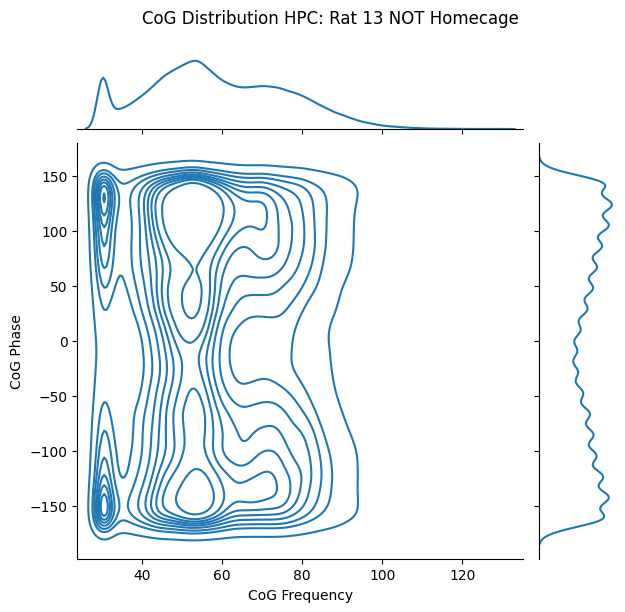

In [20]:
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1', '3','4', '6', '9', '11', '13']

#histogram_counts = np.zeros(len(histogram_bins) - 1)
frequencies = np.arange(20, 140, 1)
angles = np.arange(-180,180,19)

# Accumulate CoG frequencies across all REM states and datasets
all_cog_frequencies = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path) and "HC" not in subfolder:
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))
                    
                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                # Print debugging information
                                print(f"Processing file: {hdf5_file_path}")
                                print(f"Available groups: {list(hdf_file.keys())}")
                                current_group = hdf_file[group_name]

                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())
                                subset_frequencies = np.arange(20, 140, 1)
                                for rem_key in rem_dict_keys:
                                    # Access the 'wavelet_transform' key for the current REM period
                                    wavelet_transform = hdf_file[group_name][rem_key]['wavelet_transform'][:]
                                    print(f"The shape of wavelet_transform for {rem_key} is: {wavelet_transform.shape}")

                                    # Square each value in the matrix to get power
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                    
                                    # Z-score along the frequency axis
                                    power = zscore(power_matrix, axis=0)
                                    #power=power_matrix
                                    shifted_power = power + np.abs(np.min(power))
                                    shifted_smoothed_power = boxcar_smooth(shifted_power, (5, 21))
                                    start_end = hdf_file[group_name][rem_key]['start-end'][:]
                                    fpp_cycles = hdf_file[group_name][rem_key]['Cycles'][:]
                                    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

                                    # Calculate mean power values for the subset of frequencies
                                    fpp_plots = bin_tf_to_fpp(newcycles, shifted_smoothed_power, 19)
  
                                    
                                    
                                    x = peak_cog(frequencies, angles, fpp_plots, 0.95)
                                    # optional
                                    all_cog_frequencies.extend(x)
                                    # Import necessary libraries
                                    #import os
                                    #import pandas as pd

                                    # Specify the directory for the CSV file
                                    #csv_directory = 'E:/Donders/Weekly meeting'

                                    # Specify the name of the CSV file
                                    #csv_file_name = 'output_file.csv'

                                    # Combine the directory and file name to create the complete file path
                                    #csv_file_path = os.path.join(csv_directory, csv_file_name)

                                    # Convert the NumPy array to a DataFrame
                                    #df = pd.DataFrame(all_cog_frequencies, columns=['Column1', 'Column2'])

                                    # Save the DataFrame to a CSV file
                                    #df.to_csv(csv_file_path, index=False)

                                    #plt.hist(cog_frequencies, bins=histogram_bins, edgecolor='black')
                                    
                                    #plt.xlabel('CoG Frequency')
                                    #plt.ylabel('Frequency of Occurrence')
                                    #plt.title('Distribution of CoG Frequencies')

                                    # Show the plot
                                    #plt.show()

                                else:  # This else statement should be aligned with the inner for loop
                                    print(f"Group '{group_name}' not found in the HDF5 file.")
all_cog_frequencies = np.array(all_cog_frequencies)
# Assuming non_empty_cog_frequencies is your 2D array
g = sns.jointplot(x=all_cog_frequencies[:, 0], y=all_cog_frequencies[:, 1], kind='kde', fill=False)

# Set axis labels and plot title
g.set_axis_labels('CoG Frequency', 'CoG Phase')
g.fig.suptitle('CoG Distribution HPC: Rat 13 NOT Homecage')

# Adjust layout to make room for the title
g.fig.subplots_adjust(top=0.9)

# Show the plot
plt.show()
